In [19]:
# Eksperimen pertama
import pandas as pd
import yfinance as yf
import numpy as np
import time
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')


In [20]:

ticker = "IDR=X"
start_date = "2019-01-01"
end_date = "2024-12-31"
data = yf.download(ticker, start=start_date, end=end_date)

# Normalisasi nama kolom
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0].lower() for col in data.columns]
else:
    data.columns = [col.lower() for col in data.columns]
data.ffill(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [21]:

def create_technical_features(df):
    df_feat = df.copy()
    for i in range(1, 6):
        df_feat[f'lag_{i}'] = df_feat['close'].shift(i)
    df_feat.ta.sma(length=10, append=True)
    df_feat.ta.sma(length=30, append=True)
    df_feat.ta.rsi(length=14, append=True)
    df_feat.ta.bbands(length=20, append=True)
    df_feat.dropna(inplace=True)
    return df_feat

df_features = create_technical_features(data)


In [22]:

y = df_features['close']
X = df_features.drop(columns=['close', 'adj close'], errors='ignore')

split_percentage = 0.8
split_index = int(len(X) * split_percentage)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print(f"Data latih (X_train) shape: {X_train.shape}")
print(f"Data uji (X_test) shape: {X_test.shape}")


Data latih (X_train) shape: (1228, 17)
Data uji (X_test) shape: (307, 17)


In [23]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_features='sqrt'),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, early_stopping_rounds=10),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}


In [24]:

results = {}
predictions = {}

for name, model in models.items():
    print(f"\n--- Melatih Model: {name} ---")
    start_time = time.time()
    if name == 'XGBoost':
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:
        model.fit(X_train, y_train)
    preds = model.predict(X_test)
    predictions[name] = preds
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'MAE': mean_absolute_error(y_test, preds),
        'MAPE (%)': mean_absolute_percentage_error(y_test, preds) * 100,
        'R2 Score': r2_score(y_test, preds),
        'Waktu Latih (s)': time.time() - start_time
    }



--- Melatih Model: Random Forest ---

--- Melatih Model: XGBoost ---

--- Melatih Model: SVR ---


In [25]:

results_df = pd.DataFrame(results).T
results_df_sorted = results_df.sort_values('MAPE (%)', ascending=True)

print("\n\n" + "="*80)
print("||" + " TABEL PERBANDINGAN KINERJA MODEL ".center(76) + "||")
print("="*80)
print(results_df_sorted)
print("="*80 + "\n")





||                      TABEL PERBANDINGAN KINERJA MODEL                      ||
                      RMSE          MAE  MAPE (%)   R2 Score  Waktu Latih (s)
Random Forest   131.231370    90.095387  0.561359   0.835320         0.154278
XGBoost         147.245737   100.341466  0.626173   0.792675         0.100306
SVR            1164.253435  1101.999774  6.929794 -11.961683         0.118826



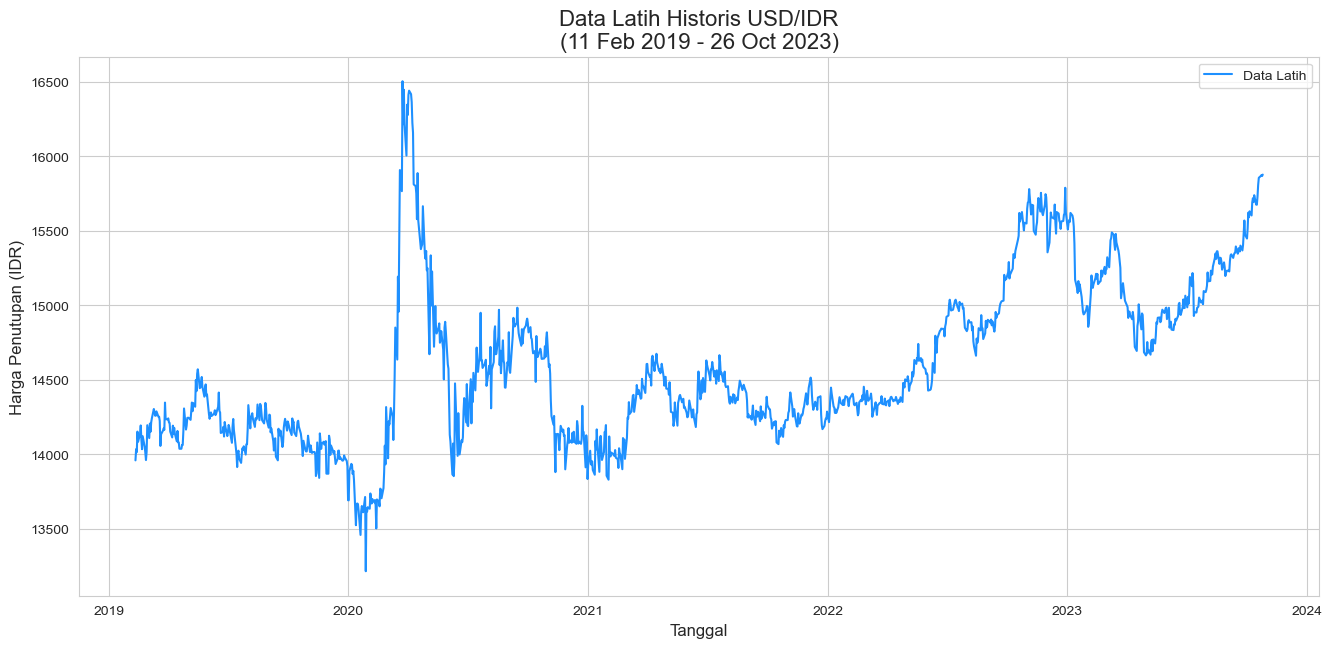

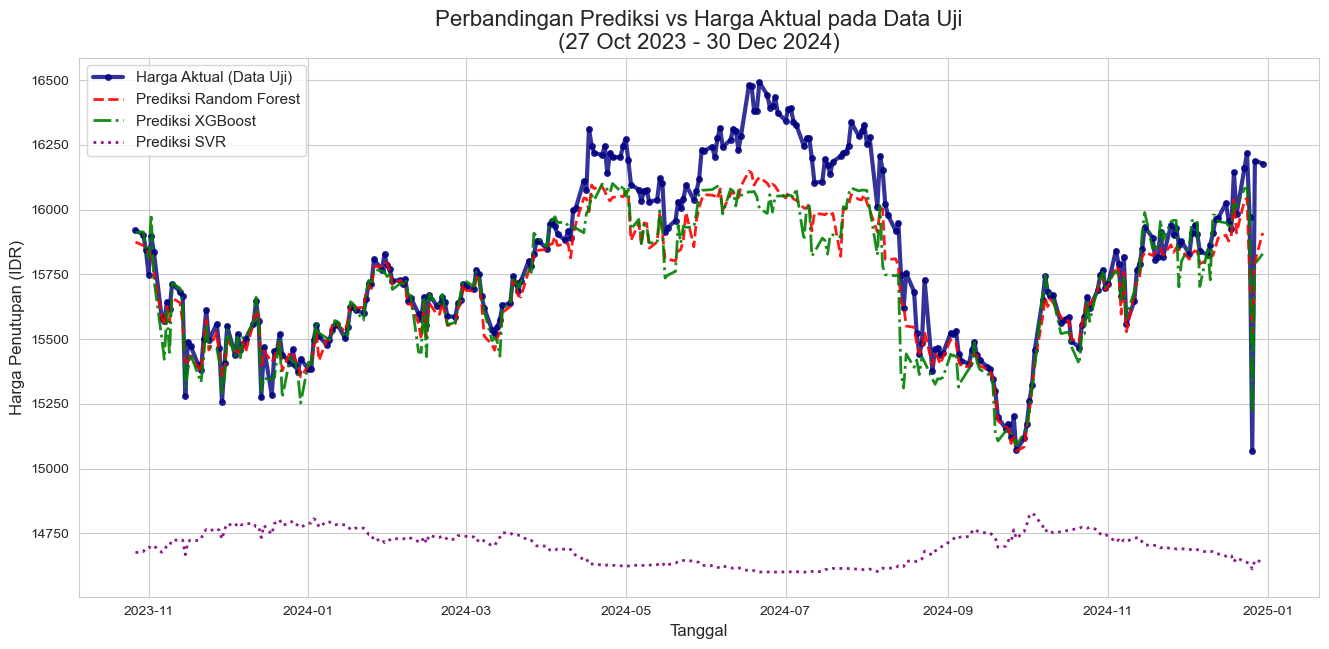

In [26]:

plt.figure(figsize=(16, 7))
train_start_date = y_train.index.min().strftime('%d %b %Y')
train_end_date = y_train.index.max().strftime('%d %b %Y')
plt.plot(y_train.index, y_train, label='Data Latih', color='dodgerblue')
plt.title(f'Data Latih Historis USD/IDR\n({train_start_date} - {train_end_date})', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga Penutupan (IDR)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 7))
test_start_date = y_test.index.min().strftime('%d %b %Y')
test_end_date = y_test.index.max().strftime('%d %b %Y')

plt.plot(y_test.index, y_test, label='Harga Aktual (Data Uji)', color='navy', linewidth=3, alpha=0.8, marker='o', markersize=4)

colors = {'Random Forest': 'red', 'XGBoost': 'green', 'SVR': 'purple'}
linestyles = {'Random Forest': '--', 'XGBoost': '-.', 'SVR': ':'}

for name, preds in predictions.items():
    plt.plot(y_test.index, preds, 
             label=f'Prediksi {name}', 
             color=colors.get(name),
             linestyle=linestyles.get(name),
             linewidth=2,
             alpha=0.9)

plt.title(f'Perbandingan Prediksi vs Harga Aktual pada Data Uji\n({test_start_date} - {test_end_date})', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga Penutupan (IDR)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True)
plt.show()



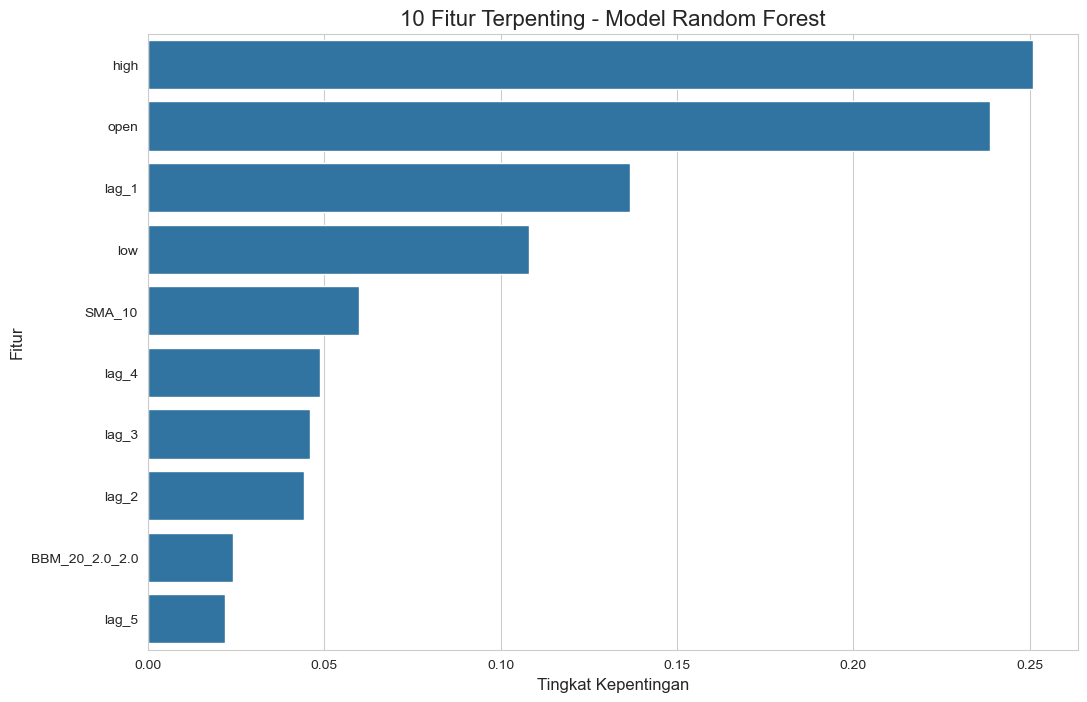

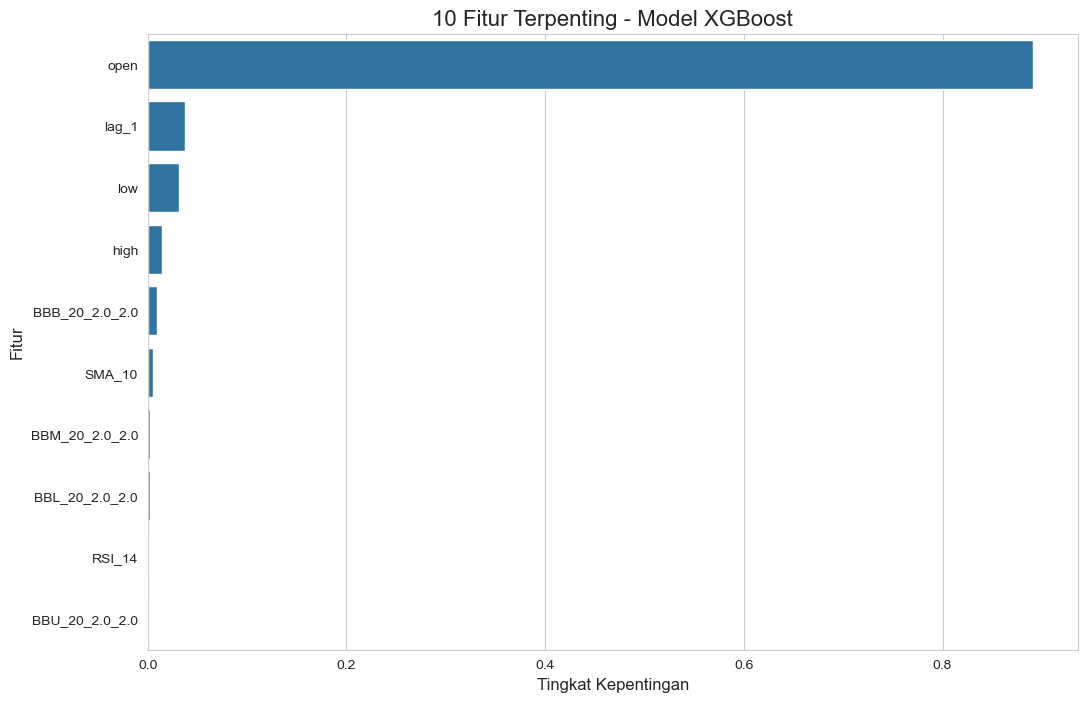


Model 'SVR' tidak memiliki atribut 'feature_importances_' untuk divisualisasikan.


In [27]:
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=importances.head(10))
        plt.title(f'10 Fitur Terpenting - Model {name}', fontsize=16)
        plt.xlabel('Tingkat Kepentingan', fontsize=12)
        plt.ylabel('Fitur', fontsize=12)
        plt.show()
    else:
        print(f"\nModel '{name}' tidak memiliki atribut 'feature_importances_' untuk divisualisasikan.")

In [28]:
# Code 60 Experimen
import pandas as pd
import yfinance as yf
import numpy as np
import time
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Library dan konfigurasi awal berhasil dimuat.")

Library dan konfigurasi awal berhasil dimuat.


In [29]:
def create_features(df, feature_config):
    """
    Membuat fitur teknikal berdasarkan konfigurasi yang diberikan.
    Fungsi ini bersifat modular dan hanya menambahkan fitur yang diminta.
    """
    df_feat = df.copy()
    
    if feature_config.get('lags'):
        for i in range(1, 6): df_feat[f'lag_{i}'] = df_feat['close'].shift(i)
    if feature_config.get('indicators'):
        df_feat.ta.sma(10, append=True); df_feat.ta.sma(30, append=True)
        df_feat.ta.rsi(14, append=True); df_feat.ta.bbands(20, append=True)
    if feature_config.get('atr'):
        df_feat.ta.atr(14, append=True)
    if feature_config.get('time_based'):
        df_feat['day_of_week'] = df_feat.index.dayofweek
        df_feat['month'] = df_feat.index.month
        df_feat['quarter'] = df_feat.index.quarter
    if feature_config.get('rolling_stats'):
        window = 7
        df_feat[f'rolling_mean_{window}'] = df_feat['close'].rolling(window=window).mean()
        df_feat[f'rolling_std_{window}'] = df_feat['close'].rolling(window=window).std()
    if feature_config.get('momentum_adv'):
        df_feat.ta.macd(append=True)
        # Pastikan kolom SMA sudah dibuat jika 'indicators' juga True
        if 'SMA_10' in df_feat.columns and 'SMA_30' in df_feat.columns:
            df_feat['sma_diff'] = df_feat['SMA_10'] - df_feat['SMA_30']
            
    df_feat.dropna(inplace=True)
    return df_feat

def prepare_data_for_model(df_features, config):
    """
    Mempersiapkan data (X, y), melakukan splitting, dan scaling.
    Fungsi ini juga menangani berbagai jenis target prediksi.
    """
    # 1. Mendefinisikan Target (y) dan Fitur (X)
    target_type = config.get('target', 'absolute')
    if target_type == 'return':
        y = df_features['close'].pct_change().dropna()
        X = df_features.iloc[:-1].copy().loc[y.index]
    elif target_type == 'delta':
        y = df_features['close'].diff().dropna()
        X = df_features.iloc[1:].copy().loc[y.index]
    else: # 'absolute'
        y = df_features['close']
        X = df_features.copy()
        
    X.drop(columns=['close', 'adj close'], errors='ignore', inplace=True)

    # 2. Seleksi Fitur (jika diaktifkan)
    if config.get('feature_selection', False) and not X.empty:
        temp_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
        temp_model.fit(X, y)
        importances = pd.Series(temp_model.feature_importances_, index=X.columns)
        top_10_features = importances.nlargest(10).index.tolist()
        X = X[top_10_features]

    # 3. Pembagian Data Latih dan Uji
    split_idx = int(len(X) * config['split_ratio'])
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # 4. Penskalaan Fitur (jika diaktifkan)
    if not config.get('no_scaling', False):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        scaler = None # Tidak ada scaler yang digunakan
        X_train_scaled = X_train.values
        X_test_scaled = X_test.values
        
    return X_train_scaled, X_test_scaled, y_train, y_test, X_train.columns, scaler

def train_and_predict(model, model_params, X_train, y_train, X_test, y_test):
    """
    Melatih model dan menghasilkan prediksi.
    Menangani kasus khusus untuk XGBoost (eval_set).
    """
    model.set_params(**model_params)
    
    if isinstance(model, XGBRegressor):
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:
        model.fit(X_train, y_train)
        
    predictions = model.predict(X_test)
    return predictions

def evaluate_predictions(predictions, y_test, original_data, target_type):
    """
    Mengevaluasi prediksi. Mengonversi prediksi kembali ke harga absolut jika diperlukan.
    """
    if target_type == 'return':
        actual_prices = original_data.loc[y_test.index, 'close']
        prev_prices = original_data['close'].shift(1).loc[y_test.index]
        predicted_prices = prev_prices * (1 + predictions)
    elif target_type == 'delta':
        actual_prices = original_data.loc[y_test.index, 'close']
        prev_prices = original_data['close'].shift(1).loc[y_test.index]
        predicted_prices = prev_prices + predictions
    else: # 'absolute'
        actual_prices = y_test
        predicted_prices = predictions

    metrics = {
        'RMSE': np.sqrt(mean_squared_error(actual_prices, predicted_prices)),
        'MAE': mean_absolute_error(actual_prices, predicted_prices),
        'MAPE (%)': mean_absolute_percentage_error(actual_prices, predicted_prices) * 100,
        'R2 Score': r2_score(actual_prices, predicted_prices)
    }
    return metrics, actual_prices, predicted_prices

print("Fungsi-fungsi utama berhasil didefinisikan.")

Fungsi-fungsi utama berhasil didefinisikan.


In [30]:
def run_experiment(data, config):
    """
    Menjalankan satu siklus eksperimen lengkap dengan memanggil fungsi-fungsi helper.
    """
    print(f"-- Menjalankan: {config['id']} ({config['name']})")
    
    # Langkah 1: Buat Fitur
    df_with_features = create_features(data, config['features'])
    
    # Langkah 2: Persiapkan Data (split, scale, dll.)
    X_train, X_test, y_train, y_test, feature_names, _ = prepare_data_for_model(df_with_features, config)
    
    # Langkah 3: Latih Model dan Prediksi
    model = config['model']
    preds = train_and_predict(model, config['model_params'], X_train, y_train, X_test, y_test)
    
    # Langkah 4: Evaluasi Hasil
    metrics, _, _ = evaluate_predictions(preds, y_test, data, config.get('target', 'absolute'))
    
    # Gabungkan hasil
    result = {'ID': config['id'], 'Model': config['model_name'], 'Eksperimen': config['name'], **metrics}
    
    return result, model, feature_names


def visualize_best_experiment(data, config, model, feature_names):
    """
    Membuat visualisasi untuk hasil eksperimen terbaik.
    """
    print(f"\nMembuat visualisasi untuk: {config['id']}")

    # Langkah-langkah ini mengulang proses untuk mendapatkan data yang tepat untuk plot
    df_with_features = create_features(data, config['features'])
    X_train, X_test, y_train, y_test, _, _ = prepare_data_for_model(df_with_features, config)
    preds = train_and_predict(model, config['model_params'], X_train, y_train, X_test, y_test)
    _, actual_prices, predicted_prices = evaluate_predictions(preds, y_test, data, config.get('target', 'absolute'))

    # Plot Prediksi vs Aktual
    plt.figure(figsize=(16, 7))
    plt.plot(actual_prices.index, actual_prices, label='Harga Aktual (Uji)', color='navy', linewidth=3)
    plt.plot(actual_prices.index, predicted_prices, label=f'Prediksi {config["id"]}', color='red', linestyle='--')
    plt.title(f'Hasil Prediksi Terbaik: {config["id"]} - {config["name"]}', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Harga Penutupan (IDR)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Feature Importance (jika ada)
    if hasattr(model, 'feature_importances_'):
        importances = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=importances.head(10))
        plt.title(f'10 Fitur Terpenting - {config["id"]}', fontsize=16)
        plt.show()

print("Fungsi eksekusi dan visualisasi berhasil didefinisikan.")

Fungsi eksekusi dan visualisasi berhasil didefinisikan.


In [31]:

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
xgb = XGBRegressor(random_state=42, n_jobs=-1, early_stopping_rounds=10)
svr = SVR()

base_features = {'lags': True, 'indicators': True}
adv_features_rolling = {**base_features, 'rolling_stats': True}
adv_features_momentum = {**base_features, 'momentum_adv': True}

all_configs = [

    {'id': 'RF-1', 'name': 'Data: Split 80/20 (Baseline)', 'model': rf, 'model_params': {'n_estimators': 100, 'max_features': 'sqrt'}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'RF-2', 'name': 'Fitur: Minimalis (Hanya Lags)', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': {'lags': True}, 'split_ratio': 0.8},
    {'id': 'RF-3', 'name': 'Fitur: Diperkaya (ATR)', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': {**base_features, 'atr': True}, 'split_ratio': 0.8},
    {'id': 'RF-4', 'name': 'Hyper: Lebih Banyak Pohon', 'model': rf, 'model_params': {'n_estimators': 300}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'RF-5', 'name': 'Hyper: Pohon Dangkal', 'model': rf, 'model_params': {'n_estimators': 100, 'max_depth': 5}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'RF-6', 'name': 'Hyper: Regularisasi Kuat', 'model': rf, 'model_params': {'n_estimators': 100, 'min_samples_leaf': 10}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'RF-7', 'name': 'Hyper: Semua Fitur', 'model': rf, 'model_params': {'n_estimators': 100, 'max_features': 1.0}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'RF-8', 'name': 'Data: Split 70/30', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.7},
    {'id': 'RF-9', 'name': 'Data: Split 90/10', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.9},
    {'id': 'RF-10','name': 'Target: Prediksi Return', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.8, 'target': 'return'},
    {'id': 'RF-11','name': 'Data: Split 60/40', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.6},
    {'id': 'RF-12','name': 'Fitur: Berbasis Waktu', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': {**base_features, 'time_based': True}, 'split_ratio': 0.8},
    {'id': 'RF-13','name': 'Fitur: Tanpa Indikator', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': {'lags':True}, 'split_ratio': 0.8},
    {'id': 'RF-14','name': 'Hyper: Kriteria MAE', 'model': rf, 'model_params': {'n_estimators': 100, 'criterion': 'absolute_error'}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'RF-15','name': 'Metodologi: Tanpa Scaling', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.8, 'no_scaling': True},
    {'id': 'RF-16', 'name': 'Fitur: Rolling Statistics', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': adv_features_rolling, 'split_ratio': 0.8},
    {'id': 'RF-17', 'name': 'Fitur: Interaksi & Momentum', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': adv_features_momentum, 'split_ratio': 0.8},
    {'id': 'RF-18', 'name': 'Metodologi: Seleksi Fitur', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.8, 'feature_selection': True},
    {'id': 'RF-19', 'name': 'Hyper: Kombinasi Optimal', 'model': rf, 'model_params': {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 5}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'RF-20', 'name': 'Target: Prediksi Perubahan Delta', 'model': rf, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.8, 'target': 'delta'},


    {'id': 'XGB-1', 'name': 'Data: Split 80/20 (Baseline)', 'model': xgb, 'model_params': {'n_estimators': 100, 'learning_rate': 0.1}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'XGB-2', 'name': 'Fitur: Minimalis (Hanya Lags)', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': {'lags': True}, 'split_ratio': 0.8},
    {'id': 'XGB-3', 'name': 'Fitur: Diperkaya (ATR)', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': {**base_features, 'atr': True}, 'split_ratio': 0.8},
    {'id': 'XGB-4', 'name': 'Hyper: LR Rendah', 'model': xgb, 'model_params': {'n_estimators': 500, 'learning_rate': 0.05}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'XGB-5', 'name': 'Hyper: Pohon Dangkal', 'model': xgb, 'model_params': {'n_estimators': 100, 'max_depth': 3}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'XGB-6', 'name': 'Hyper: Regularisasi Subsampling', 'model': xgb, 'model_params': {'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'XGB-7', 'name': 'Hyper: Agresif', 'model': xgb, 'model_params': {'n_estimators': 50, 'learning_rate': 0.2}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'XGB-8', 'name': 'Data: Split 70/30', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.7},
    {'id': 'XGB-9', 'name': 'Data: Split 90/10', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.9},
    {'id': 'XGB-10','name': 'Target: Prediksi Return', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.8, 'target': 'return'},
    {'id': 'XGB-11','name': 'Data: Split 60/40', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.6},
    {'id': 'XGB-12','name': 'Fitur: Berbasis Waktu', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': {**base_features, 'time_based': True}, 'split_ratio': 0.8},
    {'id': 'XGB-13','name': 'Fitur: Tanpa Indikator', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': {'lags':True}, 'split_ratio': 0.8},
    {'id': 'XGB-14','name': 'Hyper: Regularisasi L1/L2', 'model': xgb, 'model_params': {'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'XGB-15','name': 'Metodologi: Tanpa Scaling', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.8, 'no_scaling': True},
    {'id': 'XGB-16', 'name': 'Fitur: Rolling Statistics', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': adv_features_rolling, 'split_ratio': 0.8},
    {'id': 'XGB-17', 'name': 'Fitur: Interaksi & Momentum', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': adv_features_momentum, 'split_ratio': 0.8},
    {'id': 'XGB-18', 'name': 'Metodologi: Seleksi Fitur', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.8, 'feature_selection': True},
    {'id': 'XGB-19', 'name': 'Hyper: Kombinasi Optimal', 'model': xgb, 'model_params': {'n_estimators': 500, 'learning_rate': 0.02, 'subsample': 0.7, 'colsample_bytree': 0.7}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'XGB-20', 'name': 'Target: Prediksi Perubahan Delta', 'model': xgb, 'model_params': {'n_estimators': 100}, 'features': base_features, 'split_ratio': 0.8, 'target': 'delta'},

    {'id': 'SVR-1', 'name': 'Data: Split 80/20 (Baseline)', 'model': svr, 'model_params': {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'SVR-2', 'name': 'Hyper: C Tinggi', 'model': svr, 'model_params': {'C': 100}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'SVR-3', 'name': 'Hyper: C Rendah', 'model': svr, 'model_params': {'C': 0.1}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'SVR-4', 'name': 'Hyper: Epsilon Kecil', 'model': svr, 'model_params': {'epsilon': 0.01}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'SVR-5', 'name': 'Hyper: Gamma Berbeda', 'model': svr, 'model_params': {'gamma': 'auto'}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'SVR-6', 'name': 'Hyper: Combo Optimal 1', 'model': svr, 'model_params': {'C': 10, 'gamma': 0.01, 'epsilon': 0.01}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'SVR-7', 'name': 'Hyper: Kernel Linear', 'model': svr, 'model_params': {'kernel': 'linear', 'C': 1.0}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'SVR-8', 'name': 'Fitur: Minimalis (Hanya Lags)', 'model': svr, 'model_params': {}, 'features': {'lags':True}, 'split_ratio': 0.8},
    {'id': 'SVR-9', 'name': 'Data: Split 90/10', 'model': svr, 'model_params': {}, 'features': base_features, 'split_ratio': 0.9},
    {'id': 'SVR-10','name': 'Target: Prediksi Return', 'model': svr, 'model_params': {}, 'features': base_features, 'split_ratio': 0.8, 'target': 'return'},
    {'id': 'SVR-11','name': 'Data: Split 60/40', 'model': svr, 'model_params': {}, 'features': base_features, 'split_ratio': 0.6},
    {'id': 'SVR-12','name': 'Data: Split 70/30', 'model': svr, 'model_params': {}, 'features': base_features, 'split_ratio': 0.7},
    {'id': 'SVR-13','name': 'Fitur: Berbasis Waktu', 'model': svr, 'model_params': {}, 'features': {**base_features, 'time_based': True}, 'split_ratio': 0.8},
    {'id': 'SVR-14','name': 'Hyper: Kernel Polynomial', 'model': svr, 'model_params': {'kernel': 'poly', 'degree': 3}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'SVR-15','name': 'Hyper: Combo Optimal 2', 'model': svr, 'model_params': {'C': 50, 'gamma': 'scale'}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'SVR-16', 'name': 'Fitur: Rolling Statistics', 'model': svr, 'model_params': {}, 'features': adv_features_rolling, 'split_ratio': 0.8},
    {'id': 'SVR-17', 'name': 'Fitur: Interaksi & Momentum', 'model': svr, 'model_params': {}, 'features': adv_features_momentum, 'split_ratio': 0.8},
    {'id': 'SVR-18', 'name': 'Metodologi: Seleksi Fitur', 'model': svr, 'model_params': {}, 'features': base_features, 'split_ratio': 0.8, 'feature_selection': True},
    {'id': 'SVR-19', 'name': 'Hyper: Kombinasi Optimal Agresif', 'model': svr, 'model_params': {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}, 'features': base_features, 'split_ratio': 0.8},
    {'id': 'SVR-20', 'name': 'Target: Prediksi Perubahan Delta', 'model': svr, 'model_params': {}, 'features': base_features, 'split_ratio': 0.8, 'target': 'delta'},
]

for cfg in all_configs:
    cfg['model_name'] = type(cfg['model']).__name__

print(f"Total {len(all_configs)} konfigurasi eksperimen berhasil dibuat.")

Total 60 konfigurasi eksperimen berhasil dibuat.


In [32]:
ticker = "IDR=X"
start_date = "2019-01-01"
end_date = "2024-12-31"

print(f"Mengunduh data {ticker} dari {start_date} hingga {end_date}...")
raw_data = yf.download(ticker, start=start_date, end=end_date)

if isinstance(raw_data.columns, pd.MultiIndex):
    raw_data.columns = [c[0].lower() for c in raw_data.columns]
else:
    raw_data.columns = [c.lower() for c in raw_data.columns]

raw_data.ffill(inplace=True)

print("Data berhasil diunduh dan dipersiapkan.")
display(raw_data.head())

[*********************100%***********************]  1 of 1 completed

Mengunduh data IDR=X dari 2019-01-01 hingga 2024-12-31...
Data berhasil diunduh dan dipersiapkan.


,close,high,low,open,volume
Date,,,,,
2019-01-01,14460.000000,14460.0,14460.000000,14460.000000,0
2019-01-02,14460.000000,14513.0,14373.000000,14460.000000,0
2019-01-03,14409.700195,14502.5,14367.900391,14409.700195,0
2019-01-04,14375.400391,14403.0,14211.000000,14375.400391,0
2019-01-07,14267.000000,14263.0,14008.000000,14263.000000,0


In [33]:
all_results = []
models_trained = {} # Simpan model yang sudah dilatih untuk visualisasi
feature_names_map = {} # Simpan nama fitur untuk setiap model
start_total_time = time.time()

for config in all_configs:
    try:
        result, trained_model, feature_names = run_experiment(raw_data, config)
        all_results.append(result)
        models_trained[config['id']] = trained_model
        feature_names_map[config['id']] = feature_names

        print("--- Hasil Evaluasi Selesai ---")
        display(pd.DataFrame([result]).set_index('ID'))
        print("-" * 70)
        
    except Exception as e:
        print(f"!!! GAGAL: {config['id']} ({config['name']}) - Error: {e}")
        all_results.append({'ID': config['id'], 'Model': config['model_name'], 'Eksperimen': config['name'], 
                            'RMSE': np.nan, 'MAE': np.nan, 'MAPE (%)': np.nan, 'R2 Score': np.nan})

end_total_time = time.time()
print(f"\n\nEKSEKUSI SEMUA {len(all_configs)} EKSPERIMEN SELESAI.")
print(f"Total waktu yang dibutuhkan: {((end_total_time - start_total_time) / 60):.2f} menit.")

-- Menjalankan: RF-1 (Data: Split 80/20 (Baseline))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-1,RandomForestRegressor,Data: Split 80/20 (Baseline),131.23137,90.095387,0.561359,0.83532


----------------------------------------------------------------------
-- Menjalankan: RF-2 (Fitur: Minimalis (Hanya Lags))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-2,RandomForestRegressor,Fitur: Minimalis (Hanya Lags),67.794409,42.515186,0.267466,0.955368


----------------------------------------------------------------------
-- Menjalankan: RF-3 (Fitur: Diperkaya (ATR))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-3,RandomForestRegressor,Fitur: Diperkaya (ATR),156.344894,103.500752,0.643545,0.76626


----------------------------------------------------------------------
-- Menjalankan: RF-4 (Hyper: Lebih Banyak Pohon)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-4,RandomForestRegressor,Hyper: Lebih Banyak Pohon,129.426834,88.062349,0.548677,0.839818


----------------------------------------------------------------------
-- Menjalankan: RF-5 (Hyper: Pohon Dangkal)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-5,RandomForestRegressor,Hyper: Pohon Dangkal,140.942649,101.497246,0.632952,0.810045


----------------------------------------------------------------------
-- Menjalankan: RF-6 (Hyper: Regularisasi Kuat)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-6,RandomForestRegressor,Hyper: Regularisasi Kuat,132.498852,86.545408,0.539711,0.832123


----------------------------------------------------------------------
-- Menjalankan: RF-7 (Hyper: Semua Fitur)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-7,RandomForestRegressor,Hyper: Semua Fitur,94.445026,63.216792,0.394062,0.914705


----------------------------------------------------------------------
-- Menjalankan: RF-8 (Data: Split 70/30)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-8,RandomForestRegressor,Data: Split 70/30,102.807081,58.523688,0.36743,0.946606


----------------------------------------------------------------------
-- Menjalankan: RF-9 (Data: Split 90/10)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-9,RandomForestRegressor,Data: Split 90/10,52.462758,32.913137,0.204444,0.979893


----------------------------------------------------------------------
-- Menjalankan: RF-10 (Target: Prediksi Return)
!!! GAGAL: RF-10 (Target: Prediksi Return) - Error: "[Timestamp('2024-12-30 00:00:00')] not in index"
-- Menjalankan: RF-11 (Data: Split 60/40)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-11,RandomForestRegressor,Data: Split 60/40,136.769089,94.55652,0.599936,0.896217


----------------------------------------------------------------------
-- Menjalankan: RF-12 (Fitur: Berbasis Waktu)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-12,RandomForestRegressor,Fitur: Berbasis Waktu,102.150663,67.837138,0.422543,0.900219


----------------------------------------------------------------------
-- Menjalankan: RF-13 (Fitur: Tanpa Indikator)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-13,RandomForestRegressor,Fitur: Tanpa Indikator,84.273775,59.910824,0.374906,0.931033


----------------------------------------------------------------------
-- Menjalankan: RF-14 (Hyper: Kriteria MAE)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-14,RandomForestRegressor,Hyper: Kriteria MAE,145.847587,89.882764,0.557196,0.796593


----------------------------------------------------------------------
-- Menjalankan: RF-15 (Metodologi: Tanpa Scaling)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-15,RandomForestRegressor,Metodologi: Tanpa Scaling,145.850727,89.909372,0.557371,0.796585


----------------------------------------------------------------------
-- Menjalankan: RF-16 (Fitur: Rolling Statistics)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-16,RandomForestRegressor,Fitur: Rolling Statistics,156.311968,99.108902,0.614517,0.766358


----------------------------------------------------------------------
-- Menjalankan: RF-17 (Fitur: Interaksi & Momentum)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-17,RandomForestRegressor,Fitur: Interaksi & Momentum,169.889718,104.287669,0.645937,0.724005


----------------------------------------------------------------------
-- Menjalankan: RF-18 (Metodologi: Seleksi Fitur)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-18,RandomForestRegressor,Metodologi: Seleksi Fitur,87.030434,54.566405,0.339693,0.927572


----------------------------------------------------------------------
-- Menjalankan: RF-19 (Hyper: Kombinasi Optimal)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-19,RandomForestRegressor,Hyper: Kombinasi Optimal,147.661755,93.874952,0.581864,0.791502


----------------------------------------------------------------------
-- Menjalankan: RF-20 (Target: Prediksi Perubahan Delta)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-20,RandomForestRegressor,Target: Prediksi Perubahan Delta,105.513167,62.741882,0.397685,0.893542


----------------------------------------------------------------------
-- Menjalankan: XGB-1 (Data: Split 80/20 (Baseline))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-1,XGBRegressor,Data: Split 80/20 (Baseline),171.426905,111.263449,0.692603,0.718988


----------------------------------------------------------------------
-- Menjalankan: XGB-2 (Fitur: Minimalis (Hanya Lags))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-2,XGBRegressor,Fitur: Minimalis (Hanya Lags),84.666683,59.003963,0.370966,0.930389


----------------------------------------------------------------------
-- Menjalankan: XGB-3 (Fitur: Diperkaya (ATR))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-3,XGBRegressor,Fitur: Diperkaya (ATR),201.108865,131.431424,0.817198,0.613251


----------------------------------------------------------------------
-- Menjalankan: XGB-4 (Hyper: LR Rendah)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-4,XGBRegressor,Hyper: LR Rendah,173.905653,112.318677,0.699173,0.710803


----------------------------------------------------------------------
-- Menjalankan: XGB-5 (Hyper: Pohon Dangkal)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-5,XGBRegressor,Hyper: Pohon Dangkal,129.21623,87.586259,0.545739,0.840338


----------------------------------------------------------------------
-- Menjalankan: XGB-6 (Hyper: Regularisasi Subsampling)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-6,XGBRegressor,Hyper: Regularisasi Subsampling,138.432853,93.929058,0.584983,0.81675


----------------------------------------------------------------------
-- Menjalankan: XGB-7 (Hyper: Agresif)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-7,XGBRegressor,Hyper: Agresif,155.456241,102.393513,0.637476,0.768909


----------------------------------------------------------------------
-- Menjalankan: XGB-8 (Data: Split 70/30)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-8,XGBRegressor,Data: Split 70/30,94.02953,61.974402,0.391043,0.955334


----------------------------------------------------------------------
-- Menjalankan: XGB-9 (Data: Split 90/10)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-9,XGBRegressor,Data: Split 90/10,72.733753,51.029532,0.31928,0.961353


----------------------------------------------------------------------
-- Menjalankan: XGB-10 (Target: Prediksi Return)
!!! GAGAL: XGB-10 (Target: Prediksi Return) - Error: "[Timestamp('2024-12-30 00:00:00')] not in index"
-- Menjalankan: XGB-11 (Data: Split 60/40)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-11,XGBRegressor,Data: Split 60/40,185.771756,133.062548,0.844199,0.808525


----------------------------------------------------------------------
-- Menjalankan: XGB-12 (Fitur: Berbasis Waktu)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-12,XGBRegressor,Fitur: Berbasis Waktu,135.85432,89.576111,0.557764,0.823513


----------------------------------------------------------------------
-- Menjalankan: XGB-13 (Fitur: Tanpa Indikator)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-13,XGBRegressor,Fitur: Tanpa Indikator,83.325487,60.945375,0.383951,0.932577


----------------------------------------------------------------------
-- Menjalankan: XGB-14 (Hyper: Regularisasi L1/L2)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-14,XGBRegressor,Hyper: Regularisasi L1/L2,149.541332,99.761926,0.621014,0.78616


----------------------------------------------------------------------
-- Menjalankan: XGB-15 (Metodologi: Tanpa Scaling)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-15,XGBRegressor,Metodologi: Tanpa Scaling,149.541332,99.761926,0.621014,0.78616


----------------------------------------------------------------------
-- Menjalankan: XGB-16 (Fitur: Rolling Statistics)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-16,XGBRegressor,Fitur: Rolling Statistics,147.736952,99.492477,0.619234,0.791289


----------------------------------------------------------------------
-- Menjalankan: XGB-17 (Fitur: Interaksi & Momentum)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-17,XGBRegressor,Fitur: Interaksi & Momentum,116.282192,79.816505,0.499322,0.870702


----------------------------------------------------------------------
-- Menjalankan: XGB-18 (Metodologi: Seleksi Fitur)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-18,XGBRegressor,Metodologi: Seleksi Fitur,113.530055,78.957286,0.493755,0.87675


----------------------------------------------------------------------
-- Menjalankan: XGB-19 (Hyper: Kombinasi Optimal)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-19,XGBRegressor,Hyper: Kombinasi Optimal,123.583361,85.092996,0.530514,0.853955


----------------------------------------------------------------------
-- Menjalankan: XGB-20 (Target: Prediksi Perubahan Delta)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-20,XGBRegressor,Target: Prediksi Perubahan Delta,104.691694,62.410336,0.395759,0.895193


----------------------------------------------------------------------
-- Menjalankan: SVR-1 (Data: Split 80/20 (Baseline))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-1,SVR,Data: Split 80/20 (Baseline),1164.253435,1101.999774,6.929794,-11.961683


----------------------------------------------------------------------
-- Menjalankan: SVR-2 (Hyper: C Tinggi)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-2,SVR,Hyper: C Tinggi,448.933702,282.845256,1.752206,-0.927218


----------------------------------------------------------------------
-- Menjalankan: SVR-3 (Hyper: C Rendah)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-3,SVR,Hyper: C Rendah,1379.635219,1339.928901,8.442233,-17.200985


----------------------------------------------------------------------
-- Menjalankan: SVR-4 (Hyper: Epsilon Kecil)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-4,SVR,Hyper: Epsilon Kecil,1379.660935,1339.955883,8.442404,-17.201664


----------------------------------------------------------------------
-- Menjalankan: SVR-5 (Hyper: Gamma Berbeda)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-5,SVR,Hyper: Gamma Berbeda,1378.95609,1339.19181,8.437546,-17.183071


----------------------------------------------------------------------
-- Menjalankan: SVR-6 (Hyper: Combo Optimal 1)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-6,SVR,Hyper: Combo Optimal 1,443.220258,353.540133,2.205825,-0.878476


----------------------------------------------------------------------
-- Menjalankan: SVR-7 (Hyper: Kernel Linear)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-7,SVR,Hyper: Kernel Linear,56.010345,35.772942,0.227161,0.970001


----------------------------------------------------------------------
-- Menjalankan: SVR-8 (Fitur: Minimalis (Hanya Lags))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-8,SVR,Fitur: Minimalis (Hanya Lags),68.697854,41.627481,0.264077,0.954171


----------------------------------------------------------------------
-- Menjalankan: SVR-9 (Data: Split 90/10)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-9,SVR,Data: Split 90/10,64.644461,37.013144,0.235134,0.969471


----------------------------------------------------------------------
-- Menjalankan: SVR-10 (Target: Prediksi Return)
!!! GAGAL: SVR-10 (Target: Prediksi Return) - Error: "[Timestamp('2024-12-30 00:00:00')] not in index"
-- Menjalankan: SVR-11 (Data: Split 60/40)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-11,SVR,Data: Split 60/40,54.416393,37.91069,0.242928,0.983571


----------------------------------------------------------------------
-- Menjalankan: SVR-12 (Data: Split 70/30)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-12,SVR,Data: Split 70/30,50.046894,31.300617,0.200576,0.987347


----------------------------------------------------------------------
-- Menjalankan: SVR-13 (Fitur: Berbasis Waktu)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-13,SVR,Fitur: Berbasis Waktu,56.549831,36.659113,0.232677,0.969421


----------------------------------------------------------------------
-- Menjalankan: SVR-14 (Hyper: Kernel Polynomial)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-14,SVR,Hyper: Kernel Polynomial,1343.760928,1312.453419,8.273458,-16.266741


----------------------------------------------------------------------
-- Menjalankan: SVR-15 (Hyper: Combo Optimal 2)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-15,SVR,Hyper: Combo Optimal 2,1857.070992,1269.61643,7.889114,-31.977928


----------------------------------------------------------------------
-- Menjalankan: SVR-16 (Fitur: Rolling Statistics)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-16,SVR,Fitur: Rolling Statistics,1858.369263,1268.423655,7.880267,-32.024054


----------------------------------------------------------------------
-- Menjalankan: SVR-17 (Fitur: Interaksi & Momentum)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-17,SVR,Fitur: Interaksi & Momentum,2108.375798,1482.32191,9.225975,-41.50719


----------------------------------------------------------------------
-- Menjalankan: SVR-18 (Metodologi: Seleksi Fitur)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-18,SVR,Metodologi: Seleksi Fitur,1712.506385,1177.648842,7.319405,-27.043405


----------------------------------------------------------------------
-- Menjalankan: SVR-19 (Hyper: Kombinasi Optimal Agresif)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-19,SVR,Hyper: Kombinasi Optimal Agresif,330.617257,191.71501,1.186521,-0.045243


----------------------------------------------------------------------
-- Menjalankan: SVR-20 (Target: Prediksi Perubahan Delta)
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-20,SVR,Target: Prediksi Perubahan Delta,64.497892,33.159968,0.208432,0.960221


----------------------------------------------------------------------


EKSEKUSI SEMUA 60 EKSPERIMEN SELESAI.
Total waktu yang dibutuhkan: 0.22 menit.




||                      TABEL RINGKASAN SEMUA EKSPERIMEN                      ||


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-12,SVR,Data: Split 70/30,50.046894,31.300617,0.200576,0.987347
RF-9,RandomForestRegressor,Data: Split 90/10,52.462758,32.913137,0.204444,0.979893
SVR-20,SVR,Target: Prediksi Perubahan Delta,64.497892,33.159968,0.208432,0.960221
SVR-7,SVR,Hyper: Kernel Linear,56.010345,35.772942,0.227161,0.970001
SVR-13,SVR,Fitur: Berbasis Waktu,56.549831,36.659113,0.232677,0.969421
SVR-9,SVR,Data: Split 90/10,64.644461,37.013144,0.235134,0.969471
SVR-11,SVR,Data: Split 60/40,54.416393,37.910690,0.242928,0.983571
SVR-8,SVR,Fitur: Minimalis (Hanya Lags),68.697854,41.627481,0.264077,0.954171
RF-2,RandomForestRegressor,Fitur: Minimalis (Hanya Lags),67.794409,42.515186,0.267466,0.955368




********************************************************************************
*                        ANALISIS PEMENANG KESELURUHAN                         *
********************************************************************************

Eksperimen terbaik adalah: 'SVR-12 - Data: Split 70/30'

--- Metrik Evaluasi Terbaik ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
SVR-12,SVR,Data: Split 70/30,50.046894,31.300617,0.200576,0.987347


********************************************************************************


Membuat visualisasi untuk: SVR-12


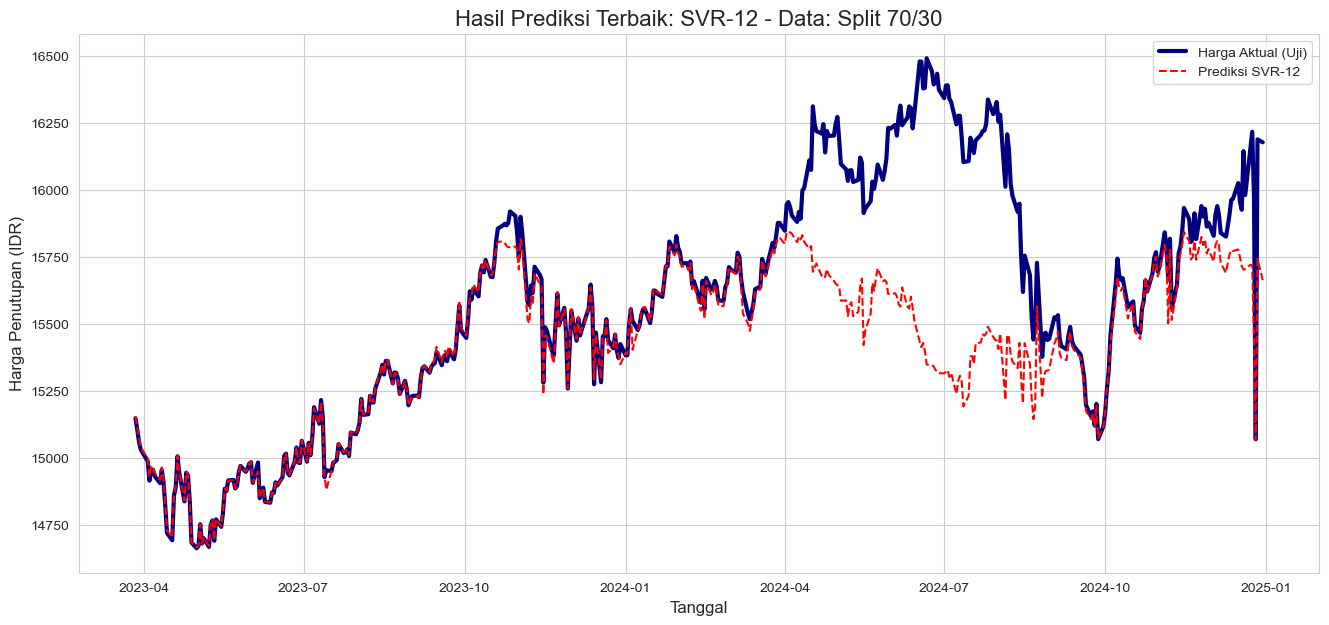

In [34]:
results_df = pd.DataFrame(all_results).set_index('ID')
results_df_sorted = results_df.sort_values('MAPE (%)', ascending=True)

print("\n\n" + "="*80)
print("||" + " TABEL RINGKASAN SEMUA EKSPERIMEN ".center(76) + "||")
print("="*80)
pd.set_option('display.width', 120)
pd.set_option('display.max_rows', len(all_configs) + 5)
display(results_df_sorted)
print("="*80 + "\n")

# Cari hasil terbaik dan visualisasikan
if not results_df_sorted.empty and pd.notna(results_df_sorted.iloc[0]['MAPE (%)']):
    best_id = results_df_sorted.index[0]
    best_result = results_df_sorted.loc[best_id]
    best_config = next((c for c in all_configs if c['id'] == best_id), None)
    best_model = models_trained.get(best_id)
    best_feature_names = feature_names_map.get(best_id)

    print("\n" + "*"*80)
    print("*" + " ANALISIS PEMENANG KESELURUHAN ".center(78) + "*")
    print("*"*80)
    print(f"\nEksperimen terbaik adalah: '{best_id} - {best_result['Eksperimen']}'")
    print("\n--- Metrik Evaluasi Terbaik ---")
    display(pd.DataFrame(best_result).T)
    print("*"*80 + "\n")

    if best_config and best_model:
        visualize_best_experiment(raw_data, best_config, best_model, best_feature_names)
else:
    print("Tidak ada hasil eksperimen yang berhasil untuk dianalisis.")